In [1]:
!pip install kaggle


In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d "hsankesara/flickr-image-dataset"


100% 8.15G/8.16G [01:11<00:00, 176MB/s]
100% 8.16G/8.16G [01:11<00:00, 123MB/s]


In [4]:
!unzip flickr-image-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [3]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/content/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)


In [4]:
print(type(content))


<class 'dict'>


In [5]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 1955246


In [6]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 18079


In [7]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [8]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 5136


In [9]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/content/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("/content/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [10]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [11]:
train_data[:5]


['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [12]:
# For each imageID in train_data, store its captions in a dictionary

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [13]:
train_content['1000268201']


['startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq',
 'startseq a little girl in a pink dress going into a wooden cabin  endseq',
 'startseq a little girl climbing the stairs to her playhouse  endseq',
 'startseq a little girl climbing into a wooden playhouse  endseq',
 'startseq a girl going into a wooden building  endseq']

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))


In [15]:
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [17]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

(1, 224, 224, 3)


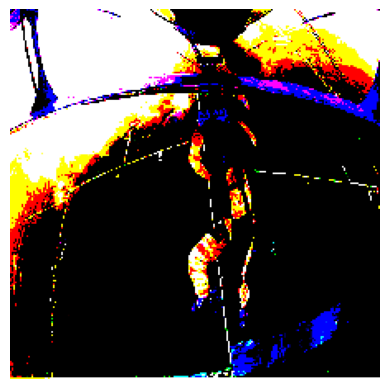

In [18]:
import matplotlib.pyplot as plt
import keras.utils as image

%matplotlib inline

img = preprocess_image("/content/flickr30k_images/flickr30k_images/726414.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [19]:
# Wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [28]:
from time import time

train_encoding = {}
# Creating dictionary of ImageID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "/content/flickr30k_images/flickr30k_images/" + imageID + ".jpg"

    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Encoding in progress... STEP 24100
1/1 [==============================] - 0s 29ms/step
Encoding in progress... STEP 24200
1/1 [==============================] - 0s 41ms/step
Encoding in progress... STEP 24300
1/1 [==============================] - 0s 27ms/step
Encoding in progress... STEP 24400
1/1 [==============================] - 0s 29ms/step
Encoding in progress... STEP 24500
1/1 [==============================] - 0s 25ms/step
Encoding in progress... STEP 24600
1/1 [==============================] - 0s 34ms/step
Encoding in progress... STEP 24700
1/1 [==============================] - 0s 26ms/step
Encoding in progress... STEP 24800
1/1 [==============================] - 0s 36ms/step
Encoding in progress... STEP 24900
1/1 [==============================] - 0s 33ms/step
Encoding in progress... STEP 25000
1/1 [==============================] - 0s 31ms/step
Encoding in progress... STE

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os
os.chdir('/content/drive/MyDrive/Image Caption Generator temp')

In [31]:
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    pickle.dump(train_encoding, file)

In [32]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "/content/flickr30k_images/flickr30k_images/" + imageID + ".jpg"

    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 [==============================] - 0s 30ms/step
Encoding in progress... STEP 0
1/1 [==============================] - 0s 22ms/step
Encoding in progress... STEP 100
1/1 [==============================] - 0s 33ms/step
Encoding in progress... STEP 200
1/1 [==============================] - 0s 29ms/step
Encoding in progress... STEP 300
1/1 [==============================] - 0s 22ms/step
Encoding in progress... STEP 400
1/1 [==============================] - 0s 26ms/step
Encoding in progress... STEP 500
1/1 [==============================] - 0s 24ms/step
Encoding in progress... STEP 600
1/1 [==============================] - 0s 33ms/step
Encoding in progress... STEP 700
1/1 [==============================] - 0s 23ms/step
Encoding in progress... STEP 800
1/1 [==============================] - 0s 30ms/step
Encoding in progress... STEP 900
1/1 [==============================] - 0s 33ms/step
Total time taken: 87.11739087104797 s


In [33]:
os.chdir('/content/drive/MyDrive/Image Caption Generator temp')

In [34]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

Pre Process the Captions

In [20]:
import os
os.chdir('/content/drive/MyDrive/Image Caption Generator temp')

In [21]:
import pickle

with open("encoded_train_features.pkl", "rb") as file:
    train_encoding = pickle.load(file)

In [22]:
import pickle

with open("encoded_test_features.pkl", "rb") as file:
    test_encoding = pickle.load(file)

In [23]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [24]:
print(len(index_to_word))


5136


In [25]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [26]:
# Add startseq and endseq also to the mappings
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [27]:
print(VOCAB_SIZE)


5139


In [40]:
import pickle
with open("/content/drive/MyDrive/Image Caption Generator temp/data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [41]:
with open("/content/drive/MyDrive/Image Caption Generator temp/data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [28]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [29]:
print(max_len)


80


In [30]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("/content/drive/MyDrive/Image Caption Generator temp/data/textFiles/glove.6B.50d.txt",encoding='utf8')

In [31]:
# Creating a mapping from word to embedding
embeddings_index = {} # empty dictionary

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [32]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [33]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_matrix.shape

(5139, 50)

Defining Model Architecture

In [35]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [36]:
#Taking Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#Specifying only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [37]:
from tensorflow.keras.layers import concatenate

# Decoding the inputs

# An image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Adding the two above tensors
decoder1 = concatenate([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 50)       256950      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

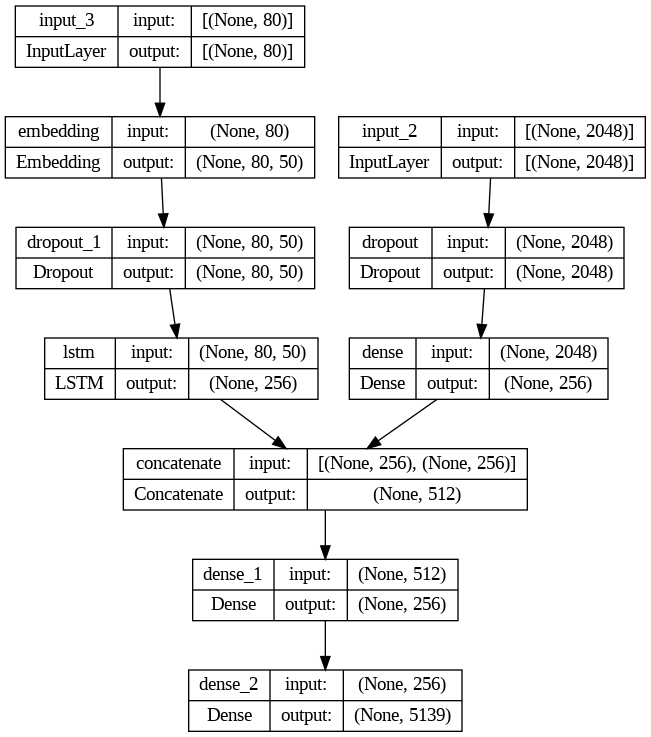

In [39]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [42]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]

                    X1, X2, y = [], [], []
                    n=0

Training the Model

In [43]:
epochs = 15
batch_size = 8
steps = len(train_content)//batch_size

In [44]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

<ipython-input-44-8e8ca74080d0>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, steps_per_epoch=steps)


3625/3625 [==============================] - 141s 39ms/step - loss: 2.8815


In [45]:
model.load_weights('/content/drive/MyDrive/Image Caption Generator temp/model_14.h5')


In [47]:
images = '/content/flickr30k_images/flickr30k_images/'

In [48]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [49]:
z = 0

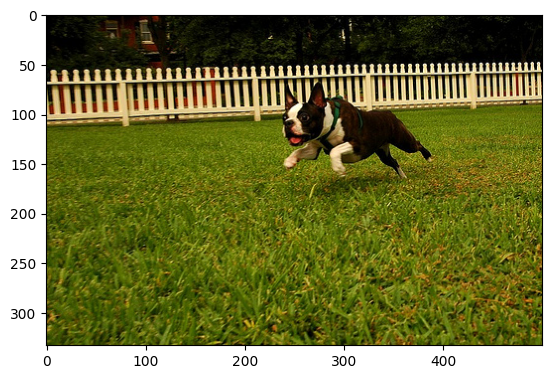

Greedy: a dog jumps over a hurdle
1009434119


In [50]:
#z = 0
z+=1
pic = list(test_encoding.keys())[z]
image = test_encoding[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(pic)

In [51]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [52]:
x = 0
pic = list(test_encoding.keys())[x]
test_content[pic]

['the man with pierced ears is wearing glasses and an orange hat ',
 'a man with glasses is wearing a beer can crocheted hat ',
 'a man with gauges and glasses is wearing a blitz hat ',
 'a man in an orange hat starring at something ',
 'a man wears an orange hat and glasses ']

102617084
Greedy Search Caption: a group of people are walking down a street

Reference 1: ['five snowmobile riders all wearing helmets and goggles line up in a snowy clearing in a forest in front of their snowmobiles they are all wearing black snow pants and from left to right they are wearing a black coat white coat red coat blue coat and black coat ', 'five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background ', 'five people wearing winter clothing helmets and ski goggles stand outside in the snow ', 'a group of snowmobile riders gather in the snow ', 'group gathered to go snowmobiling ']

BLEU-1: 0.626


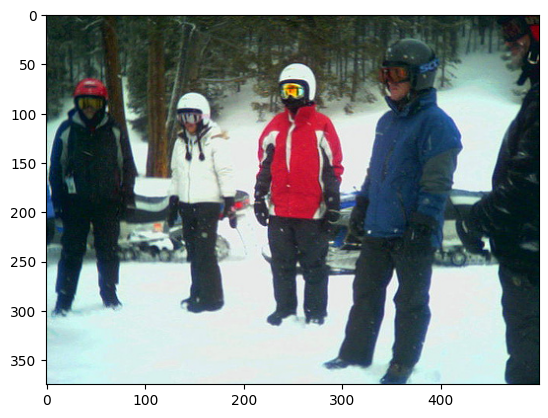

In [53]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(test_encoding.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
print(pic)
img = 'twodogs.jpg'
e = test_encoding[pic].reshape(1,2048)
#image = test_encoding[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))